In [1]:
from pathlib import Path
from scipy.io import wavfile
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import commpy

## Resources

ETSI standard (*ETSI TS 102 361*):

1. [Air interface protocol](https://www.dmrassociation.org/downloads/standards/ts_10236101v020501p.pdf)
2. [DMR voice and generic services](https://www.dmrassociation.org/downloads/standards/ts_10236102v020401p.pdf)
3. [Data protocol](https://www.dmrassociation.org/downloads/standards/ts_10236103v010301p.pdf)
4. [Trunking protocol](https://www.dmrassociation.org/downloads/standards/ts_10236104v011001p.pdf)

[DMRDecode](https://github.com/IanWraith/DMRDecode) (Java)

[mbelib](https://github.com/szechyjs/mbelib) (C++)

## Asset / Example IQ File

[SDRSharp_20160101_231914Z_12kHz_IQ.wav](https://www.sigidwiki.com/wiki/File:DMR.zip)

Source: https://www.sigidwiki.com/wiki/Digital_Mobile_Radio_(DMR)



In [12]:
def load_asset(name):
    def remove_dc_bias(file):
        dc_bias = sum(file)/len(file)
        return file - dc_bias

    def rescale_amplitude(file):
        # Rescale amplitude - not needed?
        return file * (50/np.max(file))
    
    base_path = Path(globals()['_dh'][0]).parent
    file_path = (base_path / "assets" / name).resolve()
    sample_rate, file = wavfile.read(file_path)
    print(f'Loaded {file_path}')
    num_channels = len(file.shape)
    length_s = round(file.shape[0]/sample_rate, 2)
    print(f'Sample rate: {sample_rate}Hz, channels: {num_channels}, samples: {file.shape[0]}, length: {length_s}s')
    
    return (sample_rate, remove_dc_bias(rescale_amplitude(file)))


def save_wav(file, fs, file_path='/tmp/test.wav'):
    # normalize volume
    frames = (file * (20000 / np.max(file))).astype('int16')

    w = wave.open(file_path, mode='wb')
    w.setnchannels(1)
    w.setframerate(fs)
    w.setsampwidth(2)
    w.writeframes(frames)
    w.close()
    
    print(f'Saved file to {file_path} - {round(len(file)/fs, 2)}s @ {fs}Hz')

def show_waveform(file, fs, comment=''):
    fig, ax = plt.subplots()
    ax.plot([ n/fs for n in range(0, len(file)) ], file)
    ax.set_title(f'Waveform - {comment}')
    fig.set_figwidth(20)
    ax.set_xlabel('Time [sec]')
    ax.set_ylabel('Amplitude')

In [14]:
fs, rec = load_asset('SDRSharp_20160101_231914Z_12kHz_IQ.wav')

Loaded /home/thomas/code/dmr-from-scratch/assets/SDRSharp_20160101_231914Z_12kHz_IQ.wav
Sample rate: 48000Hz, channels: 2, samples: 1636800, length: 34.1s


ValueError: only 1-dimensional arrays can be used

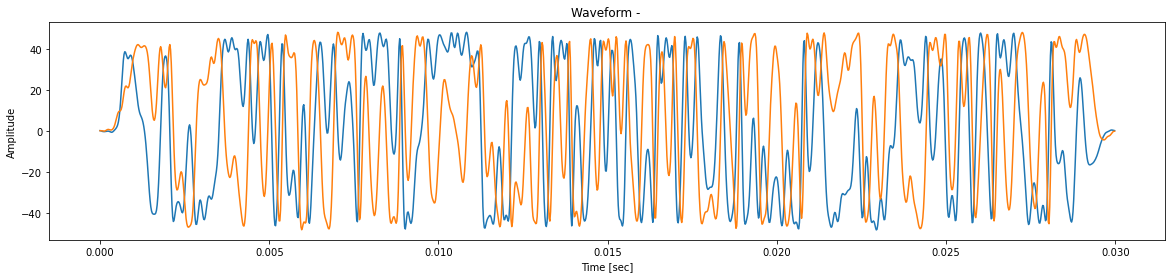

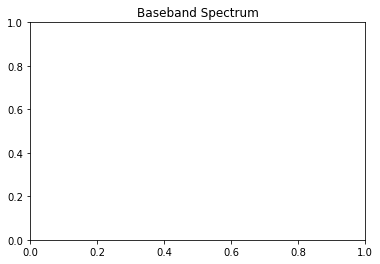

In [47]:
one_packet = rec[int(fs*5.0635):round(fs*5.0935)]
show_waveform(one_packet, fs)

fig, ax = plt.subplots()
ax.set_title('Baseband Spectrum')
ax.psd(bb, Fs=fs)

(array([4.50724182e-15, 4.44969390e-15, 4.45154934e-15, 4.36620759e-15,
        4.43638956e-15, 4.48261806e-15, 4.43689240e-15, 4.52461700e-15,
        4.53449922e-15, 4.55588481e-15, 4.53182013e-15, 4.42094313e-15,
        4.40914226e-15, 4.42995929e-15, 4.46948323e-15, 4.49347563e-15,
        4.46822311e-15, 4.49513846e-15, 4.50325907e-15, 4.32207113e-15,
        4.37657299e-15, 4.45944821e-15, 4.47474225e-15, 4.49336310e-15,
        4.55730029e-15, 4.55645993e-15, 4.53855527e-15, 4.53248957e-15,
        4.62822281e-15, 4.62256481e-15, 4.66325261e-15, 4.70525137e-15,
        4.70867996e-15, 4.61146189e-15, 4.66365047e-15, 4.72084047e-15,
        4.69428378e-15, 4.73089017e-15, 4.71822599e-15, 4.75598727e-15,
        4.79890447e-15, 4.90906001e-15, 4.90637635e-15, 4.88628220e-15,
        4.97218211e-15, 5.05724544e-15, 4.96302290e-15, 4.98720466e-15,
        5.07289300e-15, 5.04376243e-15, 5.04482350e-15, 5.17716738e-15,
        5.28721638e-15, 5.22213425e-15, 5.14461201e-15, 5.242913

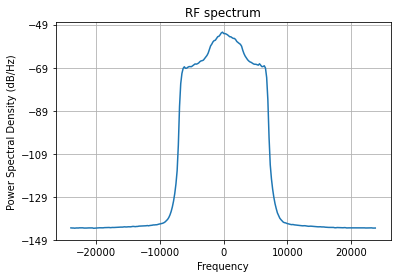

In [49]:
# read the wave file
fs, rf = wavfile.read('/home/thomas/code/dmr-from-scratch/assets/SDRSharp_20160101_231914Z_12kHz_IQ.wav')
# get the scale factor according to the data type
sf = {
    np.dtype('int16'): 2**15,
    np.dtype('int32'): 2**32,
}[rf.dtype]

# convert to complex number c = in_phase + j*quadrature and scale so that we are
# in (-1 , 1) range
rf = (rf[:, 0] + 1j * rf[:, 1]) / sf

# plot the rf signal to see the transmitting station offset
# plt.subplot(3, 3, 1)
plt.title('RF spectrum')
plt.psd(rf, Fs=fs)

(array([2.72896078e-08, 1.56557550e-09, 2.33308934e-11, 2.32756049e-12,
        6.01929980e-13, 2.17597242e-13, 9.72953433e-14, 5.08738636e-14,
        3.12041306e-14, 2.01913146e-14, 1.56126505e-14, 1.20809472e-14,
        1.03087967e-14, 9.17247982e-15, 8.10518083e-15, 7.76163033e-15,
        7.55289314e-15, 7.14069328e-15, 6.97119604e-15, 6.67457642e-15,
        6.44965319e-15, 6.41181103e-15, 6.41688243e-15, 6.20904364e-15,
        6.18242886e-15, 6.02431118e-15, 5.90442655e-15, 5.85886510e-15,
        5.79658522e-15, 5.68159037e-15, 5.62420082e-15, 5.64873258e-15,
        5.67165920e-15, 5.54664408e-15, 5.45708139e-15, 5.34632504e-15,
        5.38699443e-15, 5.40876575e-15, 5.33075615e-15, 5.28729235e-15,
        5.22911761e-15, 5.11710394e-15, 5.08441074e-15, 5.04874270e-15,
        5.07977709e-15, 5.06283256e-15, 4.97303914e-15, 5.01140813e-15,
        4.94336906e-15, 4.83868734e-15, 4.80713106e-15, 4.76684338e-15,
        4.73634894e-15, 4.70954574e-15, 4.67992442e-15, 4.727852

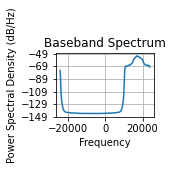

In [9]:
# # offset frequency in Hz (read from the previous plot)
# offset_frequency = 366.8e3
# # baseband local oscillator
# bb_lo = np.exp(1j * (2 * np.pi * (-offset_frequency / fs) *
#                       np.arange(0, len(rf))))

# # complex-mix to bring the rf signal to baseband (so that is centered around
# # something around 0Hz. doesn't have to be perfect.
# bb = rf * bb_lo

# # plot the mixed signal which ought to bring the signal of interest to the
# # baseband
# plt.subplot(3, 3, 2)
# plt.title('Baseband Spectrum')
# plt.psd(bb, Fs=fs)